In [63]:
# ohlc_clustering.py

import copy
import datetime
import glob

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_finance import candlestick_ohlc
from matplotlib.dates import (
    DateFormatter, WeekdayLocator, DayLocator, MONDAY
)
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

In [26]:
columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'closeT', 
            'quoteAssVol', 'numTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore']

In [27]:
# Get files names from the dataset dir
paths = []
list_of_files = glob.glob('W:/fetch_klines/klines/*')
for file_path in list_of_files:
    paths.append(file_path)

In [56]:
def get_normalized_prices(symbol, size):
    '''
    Chaque dimension représente les prix haut, bas et de clôture normalisés par une 
    moyenne a tres court terme du prix d'ouverture.
    Les colonnes restantes sont supprimées et le DataFrame est renvoyé:
    '''
    path = [x for x in paths if symbol in x][0]
    df = pd.read_json(path)
    df = df.iloc[-size:]
    df.columns = columns
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df = df.set_index('open_time')
    df['sma5'] = df['open'].rolling(window=5).mean()
    df['H/sma'] = df['high']/df['sma5']
    df['L/sma'] = df['low']/df['sma5']
    df['C/sma'] = df['close']/df['sma5']
    df.drop(
        [
            'open', 'high', 'low', 'close', 'volume', 'closeT', 
            'quoteAssVol', 'numTrades', 'takerBuyBaseVol', 
            'takerBuyQuoteVol', 'ignore', 'sma5'
        ],
        axis=1, inplace=True
    )
    df = df.dropna()
    return df

In [64]:
def plot_3d_normalised_candles(data):
    """
    Tracer un diagramme de dispersion 3D des barres normalisées
    mettant en évidence les clusters séparés par couleur.
    """
    fig = plt.figure(figsize=(12, 9))
    ax = Axes3D(fig, elev=21, azim=-136)
    ax.scatter(
        data["H/sma"], data["L/sma"], data["C/sma"],
        c=labels.astype(np.float)
    )
    ax.set_xlabel('High/sma')
    ax.set_ylabel('Low/sma')
    ax.set_zlabel('Close/sma')
    plt.show()

In [77]:
def create_follow_cluster_matrix(data):
    """
    Crée une matrice k x k, où k est le nombre de clusters
    qui apparaissent quand le cluster j suit le cluster i.
    """
    data["ClusterNextTick"] = data["Cluster"].shift(-1)
    data.dropna(inplace=True)
    data["ClusterNextTick"] = data["ClusterNextTick"].apply(int)
    eth["ClusterMatrix"] = list(zip(data["Cluster"], data["ClusterNextTick"]))
    cmvc = data["ClusterMatrix"].value_counts()
    clust_mat = np.zeros( (k, k) )
    for row in cmvc.iteritems():
        clust_mat[row[0]] = row[1]*100.0/len(data)
    print("Cluster Follow-on Matrix:")
    print(clust_mat)

In [72]:
eth = get_normalized_prices('ETHBTC', 129600)  # last 3 months of 1 min ohlc data

In [73]:
k = 5
km = KMeans(n_clusters=k, random_state=42)
km.fit(eth)
labels = km.labels_
eth["Cluster"] = labels

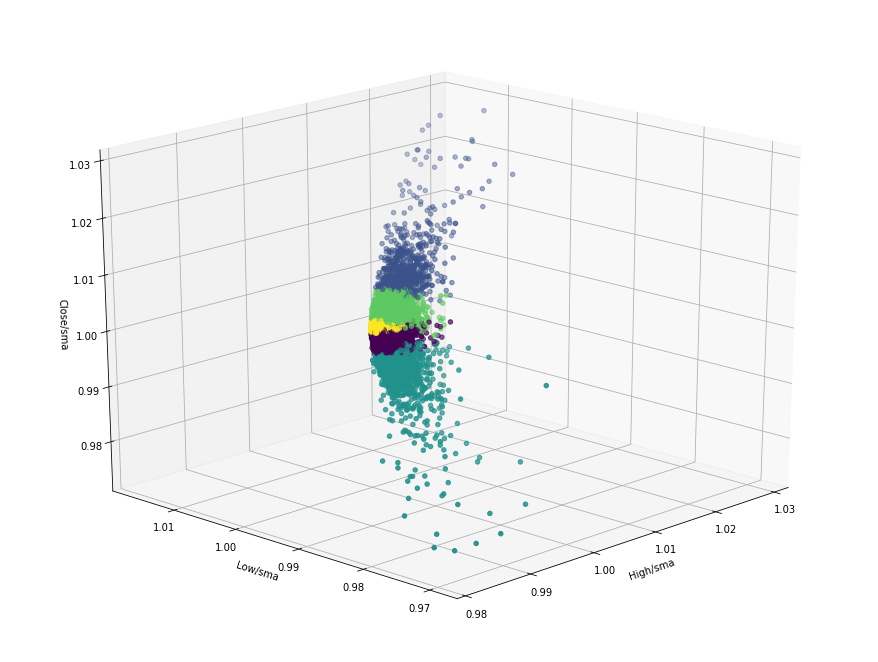

In [74]:
plot_3d_normalised_candles(eth)

La figure ci-dessus est un graphique tridimensionnel de high/sma, low/sma et close/sma les uns contre les autres. Chacune des k = 5 clusters a été colorée. Il est clair que la majorité des barres sont situés autour (1.0,1.0,1.0).

Par contre il apparait que d'avantage de minutes sont substantiellement sous le prix d'ouverture, mit en evidence par les points turquoises dans le bas du graphique.

In [78]:
# Matrice de suivi de cluster
create_follow_cluster_matrix(eth)

Cluster Follow-on Matrix:
[[1.17081038e+01 1.15746099e-02 5.06967915e-01 4.83047055e-01
  6.20321928e+00]
 [6.17312530e-03 3.60356189e-01 2.31492199e-03 2.63129466e-01
  4.62984397e-03]
 [5.77958856e-01 0.00000000e+00 7.63924256e-01 3.08656265e-02
  1.31178913e-02]
 [4.07426270e-01 2.41523527e-01 3.08656265e-02 7.42704138e+00
  4.13599395e+00]
 [6.21325061e+00 2.31492199e-02 8.17939102e-02 4.03876723e+00
  5.64648055e+01]]


On peut voir que ce n’est certainement pas une matrice uniformément répartie. C'est-à-dire que certaines "candles" sont susceptibles de suivre les autres plus fréquemment. Cela motive la possibilité de former des stratégies autour de l'identification et de la prédiction de clusters ultérieurs.